In [1]:
import os
import sys
from pathlib import Path

REPO_URL = "https://github.com/ChangeEngine/Intro-to-ML--Group-1--Final-Project.git"
REPO_DIR = Path("/content/Intro-to-ML--Group-1--Final-Project")

if "google.colab" in sys.modules:
    if not REPO_DIR.exists():
        !git clone $REPO_URL $REPO_DIR
    os.chdir(REPO_DIR)

print("Working directory:", Path.cwd())


Cloning into '/content/Intro-to-ML--Group-1--Final-Project'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 159 (delta 61), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (159/159), 12.92 MiB | 11.15 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Working directory: /content/Intro-to-ML--Group-1--Final-Project


In [2]:
from pathlib import Path

DATA_DIR = Path("data")
if not DATA_DIR.exists():
    alt = Path("..") / "data"
    if alt.exists():
        DATA_DIR = alt
    else:
        raise FileNotFoundError(
            "Could not find data/ at ./data or ../data. "

        )

print("Using data folder:", DATA_DIR.resolve())
print("Files in data/:")
for p in DATA_DIR.iterdir():
    print(" -", p.name)


Using data folder: /content/Intro-to-ML--Group-1--Final-Project/data
Files in data/:
 - t10k-images.idx3-ubyte.gz
 - t10k-labels.idx1-ubyte.gz
 - train-labels.idx1-ubyte.gz
 - train-images.idx3-ubyte.gz


In [3]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

plt.rcParams["figure.figsize"] = (4, 4)


def load_mnist_images(path):
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:16], dtype=">i4")
    magic, num_images, rows, cols = header
    assert magic == 2051, "Not an images file"

    images = np.frombuffer(data[16:], dtype=np.uint8)
    images = images.reshape(num_images, rows, cols)
    return images


def load_mnist_labels(path):
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:8], dtype=">i4")
    magic, num_labels = header
    assert magic == 2049, "Not a labels file"

    labels = np.frombuffer(data[8:], dtype=np.uint8)
    return labels


def load_mnist_dataset(images_path, labels_path, normalize=True):
    X = load_mnist_images(images_path)
    y = load_mnist_labels(labels_path)

    if normalize:
        X = X.astype("float32") / 255.0

    return X, y


In [4]:
# Paths to MNIST .gz files
train_images_path = DATA_DIR / "train-images.idx3-ubyte.gz"
train_labels_path = DATA_DIR / "train-labels.idx1-ubyte.gz"
test_images_path  = DATA_DIR / "t10k-images.idx3-ubyte.gz"
test_labels_path  = DATA_DIR / "t10k-labels.idx1-ubyte.gz"

# Load
X_train, y_train = load_mnist_dataset(train_images_path, train_labels_path)
X_test, y_test   = load_mnist_dataset(test_images_path, test_labels_path)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test :", X_test.shape, X_test.dtype)
print("y_test :", y_test.shape, y_test.dtype)

# Flatten 28x28 -> 784 features
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

print("X_train_flat:", X_train_flat.shape)
print("X_test_flat :", X_test_flat.shape)

# Train/validation split (same logic as other notebooks)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_flat,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train,
)

print("Train subset:", X_tr.shape, y_tr.shape)
print("Val subset  :", X_val.shape, y_val.shape)


X_train: (60000, 28, 28) float32
y_train: (60000,) uint8
X_test : (10000, 28, 28) float32
y_test : (10000,) uint8
X_train_flat: (60000, 784)
X_test_flat : (10000, 784)
Train subset: (48000, 784) (48000,)
Val subset  : (12000, 784) (12000,)


In [5]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7],
    "knn__weights": ["uniform", "distance"],
}

grid_knn = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",   # tune for macro F1
    cv=3,
    n_jobs=-1,
    verbose=2,
)

print("Running GridSearchCV for k-NN...")
grid_knn.fit(X_tr, y_tr)
print("Done.")

print("Best params:", grid_knn.best_params_)
print("Best CV macro F1:", grid_knn.best_score_)


Running GridSearchCV for k-NN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done.
Best params: {'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best CV macro F1: 0.9388740179832276


In [6]:
best_knn = grid_knn.best_estimator_

# Validation metrics
y_val_pred = best_knn.predict(X_val)

val_acc = accuracy_score(y_val, y_val_pred)
val_prec_macro, val_rec_macro, val_f1_macro, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average="macro"
)
val_prec_weighted, val_rec_weighted, val_f1_weighted, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average="weighted"
)

print("VALIDATION RESULTS (k-NN)")
print("Accuracy            :", val_acc)
print("Precision (macro)   :", val_prec_macro)
print("Recall (macro)      :", val_rec_macro)
print("F1-score (macro)    :", val_f1_macro)
print("Precision (weighted):", val_prec_weighted)
print("Recall (weighted)   :", val_rec_weighted)
print("F1-score (weighted) :", val_f1_weighted)

# Test metrics
y_test_pred = best_knn.predict(X_test_flat)

test_acc = accuracy_score(y_test, y_test_pred)
test_prec_macro, test_rec_macro, test_f1_macro, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="macro"
)
test_prec_weighted, test_rec_weighted, test_f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="weighted"
)

print("\nTEST RESULTS (k-NN)")
print("Accuracy            :", test_acc)
print("Precision (macro)   :", test_prec_macro)
print("Recall (macro)      :", test_rec_macro)
print("F1-score (macro)    :", test_f1_macro)
print("Precision (weighted):", test_prec_weighted)
print("Recall (weighted)   :", test_rec_weighted)
print("F1-score (weighted) :", test_f1_weighted)

print("\nClassification report (test):\n")
print(classification_report(y_test, y_test_pred))


VALIDATION RESULTS (k-NN)
Accuracy            : 0.9485
Precision (macro)   : 0.9486844221821565
Recall (macro)      : 0.9477026986083853
F1-score (macro)    : 0.947960712044367
Precision (weighted): 0.9487084703472021
Recall (weighted)   : 0.9485
F1-score (weighted) : 0.948370750071771

TEST RESULTS (k-NN)
Accuracy            : 0.9435
Precision (macro)   : 0.9435123931592109
Recall (macro)      : 0.9427297655995209
F1-score (macro)    : 0.9428996610517208
Precision (weighted): 0.9436645368439864
Recall (weighted)   : 0.9435
F1-score (weighted) : 0.9433592039740757

Classification report (test):

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.99      0.97      1135
           2       0.96      0.93      0.94      1032
           3       0.91      0.95      0.93      1010
           4       0.95      0.94      0.94       982
           5       0.93      0.92      0.93       892
           6      

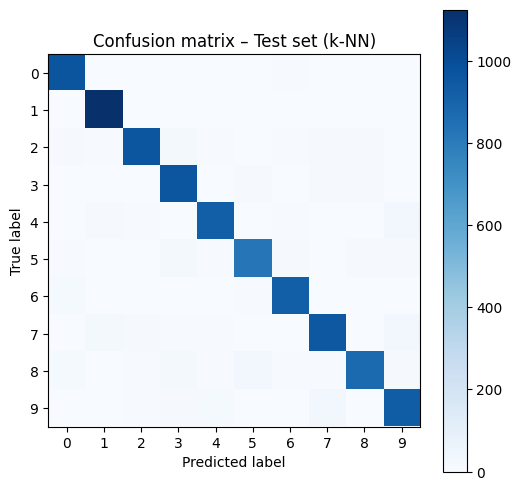

In [7]:
import numpy as np

cm_knn = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm_knn, cmap="Blues")
plt.title("Confusion matrix – Test set (k-NN)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()
